## newspred.ipynb

From A First Course in Machine Learning, Chapter 5.

Simon Rogers, 30/22/21 [simon.d.rogers@gmail.com]

Notebook to demonstrate Naive Bayes on the newsgroup data

### Data

To avoid processing the original data, we will use the `sklearn` method for accessing this data directly.

In [34]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

We will use the sklearn `Vectorizer` to turn the raw text into a bag of words form.

The result will be a documents x words matrix

The code is quite slow for making predictions if all words that appear are used, and could be made more efficient. Here, the `max_df` and `min_df` parameters below have been chosen to reduce the vocab down to words that don't appear too frequently, or too infrequently.

In [93]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.5, min_df=0.01)
train_vectors = cv.fit_transform(newsgroups_train.data)
print(train_vectors.shape)
test_vectors = cv.transform(newsgroups_test.data)

(11314, 2141)


In [94]:
import logging
import numpy as np
import pylab as plt
logging.basicConfig(level = logging.INFO)
%matplotlib inline

In [95]:
class NBTextClassifier(object):
    '''
    Class to represent a Naive Bayes text classifier
    '''
    def __init__(self, X, t, alpha=2):
        self.X = X
        self.t = t
        self.alpha = alpha
        self.classes = set(self.t)
        self.K = len(self.classes)
        self.N, self.M = X.shape # number of examples, size of vocab
        logging.info('Initialised classifier')
        
    def train(self):
        self.probs = np.zeros((self.K, self.M), float)
        self.prior = np.zeros(self.K, float)
    
        for k in range(self.K):
            pos = np.where(self.t == k)[0]
            temp = self.X[pos, :].sum(axis=0)
            temp += self.alpha - 1
            self.probs[k, :] = temp / temp.sum()
            self.prior[k] = len(pos) / self.N
        logging.info("Done training!")
        
    def classify(self, testX):
        testX = testX.toarray() # make it dense
        testN, _ = testX.shape
        logging.info("Computing predictions for %d test points", testN)
        test_probs = np.zeros((testN, self.K), float)
        test_log_like = np.zeros((testN, self.K), float)
        for k in range(self.K):
            test_log_like[:, k] = np.multiply(testX, np.log(self.probs[k, :])).sum(axis=1)
            test_log_like[:, k] += np.log(self.prior[k])
        test_log_like -= test_log_like.max(axis=1)[:, None]
        test_probs = np.exp(test_log_like)
        test_probs /= test_probs.sum(axis=1)[:, None]
        return test_probs
        
        
nb = NBTextClassifier(train_vectors, newsgroups_train.target)
nb.train()
pred_probs = nb.classify(test_vectors)

INFO:root:Initialised classifier
INFO:root:Done training!
INFO:root:Computing predictions for 7532 test points


Visualise the predictions

Text(0, 0.5, 'Index of test point')

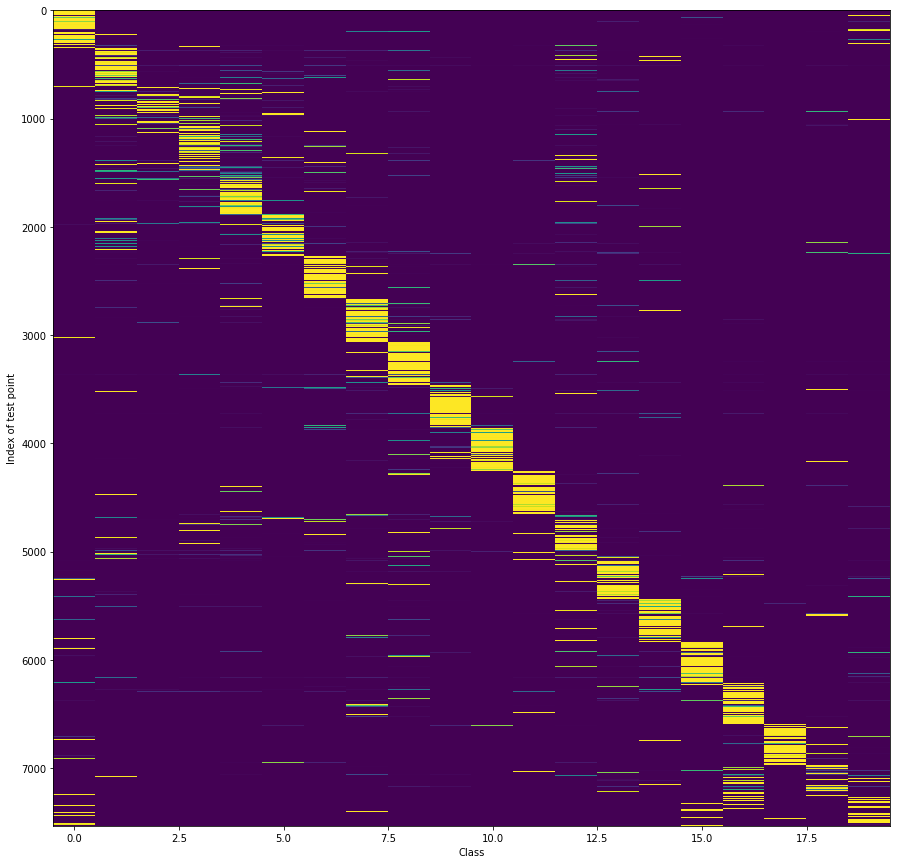

In [98]:
sort_idx = np.argsort(newsgroups_test.target)
true_labels = newsgroups_test.target[sort_idx]
sorted_pred_probs = pred_probs[sort_idx, :]


plt.figure(figsize=(15, 15))
plt.imshow(sorted_pred_probs, aspect='auto', interpolation='nearest')
plt.xlabel('Class')
plt.ylabel('Index of test point')